In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

BATCH_SIZE = 32
IMG_SIZE = (256, 256) # (you choose)
MODEL_N = 0 # (it is used just to save the models in different files.h5)
SEED = 42

# Folders containing sub-folders named after the classes.
# Images are stored in the sub-folder corresponding to their true class.
training = "training/"
test = "test/"
category_names = os.listdir(training)
nb_categories = len(category_names)
validation_split = 0.2 # (you decide)

# set the weights for each class in the loss function, according to the representation
# of each class in the training folder.
class_weight = {0: 1, 1: 1} # (you decide)

# define the model to train
def your_model(img_size=(256, 256), categories=2, k=0):
    '''
    - "categories"
        (integer) defining the number of categories for the softmax layer
    - "k"
        (integer) defining the pre-trained model:
            k == 0:     Xception
            k == 1:     ResNet50V2
            k == 2:     ResNet101V2
            k == 3:     ResNet152V2
            k == 4:     InceptionV3
            k == 5:     InceptionResNetV2
            k == 6:     EfficientNetB4
            k == 7:     EfficientNetB5
            k == 8:     EfficientNetB6
            k == 9:     EfficientNetB7
    '''
    input_shape = img_size + (3,)
    if k == 0:
        base_model = tf.keras.applications.Xception(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 1:
        base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 2:
        base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 3:
        base_model = tf.keras.applications.ResNet152V2(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 4:
        base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 5:
        base_model = tf.keras.applications.InceptionResNetV2(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 6:
        base_model = tf.keras.applications.EfficientNetB4(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 7:
        base_model = tf.keras.applications.EfficientNetB5(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 8:
        base_model = tf.keras.applications.EfficientNetB6(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    elif k == 9:
        base_model = tf.keras.applications.EfficientNetB7(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet') # From imageNet
    
    # freeze all layers.
    base_model.trainable = False
    
    # define the input tensor.
    inputs = tf.keras.Input(shape=input_shape)
    
    # preprocess the input images according to the pre-trained model used. 
    # "preprocess_input" is a keras function called during the execution of the main.
    x = preprocess_input(inputs)
    
    # pass the preprocessed inputs to the selected pretrained model.
    x = base_model(x, training=False)
    
    # apply "Dropout" on the activation maps of the last convolutional layer, 
    # before passing them to the "GAP".
    x = tfl.Dropout(rate=0.2, name='dropout_1')(x) # (I don't think you need this)
    x = tfl.GlobalAveragePooling2D(name='gap')(x)
    
    # apply "Dropout" on the output vector of the "GAP", 
    # before passing it to the "Softmax" layer.
    x = tfl.Dropout(rate=0.4, name='dropout_2')(x)
    
    # the parameters of the "Softmax" layer are also regularized using the L2-norm.
    outputs = tfl.Dense(categories, activation='softmax', 
                        bias_regularizer=tf.keras.regularizers.l2(1e-4), 
                        activity_regularizer=tf.keras.regularizers.l2(1e-5), 
                        name='softmax')(x)
    
    # the model is created, passing as arguments, the input and the output of the
    # computational graph.
    model = tf.keras.Model(inputs, outputs)
    return model


In [2]:
# For Loop ·······················································································
accs = []
val_accs = []
losses = []
val_losses = []

# this for loop compute a fitted model for each of the 10 pre-trained models in use.
used_models = [0, 1]
for kkk in used_models:
    tf.keras.backend.clear_session()
    
    # prepare the training set.
    train_datagen = ImageDataGenerator(rotation_range=40, 
                                        width_shift_range=0.2, height_shift_range=0.2, 
                                        brightness_range=[0.7, 1.3], 
                                        zoom_range=0.2, 
                                        fill_mode='constant', cval=0, 
                                        horizontal_flip=True, vertical_flip=True, 
                                        validation_split=validation_split)
    
    train_dataset = train_datagen.flow_from_directory(training, 
                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
                                        class_mode='categorical', 
                                        subset='training', 
                                        shuffle=True, seed=SEED+kkk*3)
    
    # prepare the validation set.
    valid_datagen = ImageDataGenerator(validation_split=validation_split)
    
    validation_dataset = valid_datagen.flow_from_directory(training, 
                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
                                        class_mode='categorical', 
                                        subset='validation', 
                                        shuffle=True, seed=SEED+kkk*3)
    
    # choose the preprocessing function according to the selected pre-trained model.
    if kkk == 0:
        preprocess_input = tf.keras.applications.xception.preprocess_input
    elif kkk in [1, 2, 3]:
        preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    elif kkk == 4:
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    elif kkk == 5:
        preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    elif kkk in [6, 7, 8, 9]:
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input

    # load the model using the function defined in the previous cell of this notebook.
    model2 = your_model(IMG_SIZE, nb_categories, kkk)
    
    # ····························································································
    # Transfer Learning ··········································································
    # compile the model.
    base_learning_rate = 0.001
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss='categorical_crossentropy', metrics=['accuracy'])
    
    # model fit.
    initial_epochs = 7
    history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, 
                         class_weight=class_weight, verbose=1)
    
    # store the history of the model fitted using transfer learning.
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # ····························································································
    # Fine Tuning ················································································
    # choose which layers to unfreeze, according the the selected pre-trained model.
    if kkk == 0:
        base_model = model2.layers[3]
        fine_tune_at = 96 # (un-freeze from "block11_sepconv1_act" and below)
    elif kkk == 1:
        base_model = model2.layers[3]
        fine_tune_at = 154 # (un-freeze from "conv5_block1_preact_bn" and below)
    elif kkk == 2:
        base_model = model2.layers[3]
        fine_tune_at = 341 # (un-freeze from "conv5_block1_preact_bn" and below)
    elif kkk == 3:
        base_model = model2.layers[3]
        fine_tune_at = 528 # (un-freeze from "conv5_block1_preact_bn" and below)
    elif kkk == 4:
        base_model = model2.layers[3]
        fine_tune_at = 249 # (un-freeze from "conv2d_385" and below)
    elif kkk == 5:
        base_model = model2.layers[3]
        fine_tune_at = 630 # (un-freeze from "block8_1_mixed" and below)
    elif kkk == 6:
        base_model = model2.layers[1]
        fine_tune_at = 443 # (un-freeze from "block7a_expand_conv" and below)
    elif kkk == 7:
        base_model = model2.layers[1]
        fine_tune_at = 530 # (un-freeze from "block7a_expand_conv" and below)
    elif kkk == 8:
        base_model = model2.layers[1]
        fine_tune_at = 620 # (un-freeze from "block7a_expand_conv" and below)
    elif kkk == 9:
        base_model = model2.layers[1]
        fine_tune_at = 752 # (un-freeze from "block7a_expand_conv" and below)
    
    # un-freeze everything, then re-freeze all the layers up to the chosen layer.
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # compile the model and set checkpoint and earlystopping criteria.
    model2.compile(optimizer=Adam(learning_rate=0.1*base_learning_rate, amsgrad=True), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    checkpoint = ModelCheckpoint(f'model{MODEL_N+kkk}_fineTuned.h5', monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    earlystop = EarlyStopping(monitor="val_loss", min_delta=0.005, patience=10,
                    verbose=1, restore_best_weights=True)
    
    # model fit
    fine_tune_epochs = 53
    total_epochs =  initial_epochs + fine_tune_epochs
    history_fine = model2.fit(train_dataset, validation_data=validation_dataset, 
                            epochs=total_epochs, initial_epoch=history.epoch[-1]+1, class_weight=class_weight, 
                            verbose=1, callbacks=[checkpoint, earlystop])
    
    # add the history of the fitted fine-tuned model to the previous one.
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    
    # append the history of all the fitted models in the corresponding lists.
    accs.append(acc)
    val_accs.append(val_acc)
    losses.append(loss)
    val_losses.append(val_loss)

Found 32589 images belonging to 14 classes.
Found 21717 images belonging to 14 classes.
Epoch 1/7
1019/1019 [==============================] - 663s 646ms/step - loss: 2.8873 - accuracy: 0.8260 - val_loss: 0.4964 - val_accuracy: 0.8487
Epoch 2/7
1019/1019 [==============================] - 661s 648ms/step - loss: 1.4477 - accuracy: 0.8987 - val_loss: 0.4315 - val_accuracy: 0.8666
Epoch 3/7
1019/1019 [==============================] - 662s 649ms/step - loss: 1.1599 - accuracy: 0.9155 - val_loss: 0.3896 - val_accuracy: 0.8771
Epoch 4/7
1019/1019 [==============================] - 512s 502ms/step - loss: 1.0250 - accuracy: 0.9224 - val_loss: 0.3772 - val_accuracy: 0.8816
Epoch 5/7
1019/1019 [==============================] - 475s 466ms/step - loss: 0.9576 - accuracy: 0.9274 - val_loss: 0.4253 - val_accuracy: 0.8664
Epoch 6/7
1019/1019 [==============================] - 441s 433ms/step - loss: 0.8794 - accuracy: 0.9310 - val_loss: 0.4067 - val_accuracy: 0.8740
Epoch 7/7
1019/1019 [=========

C:\Users\fuge\anaconda3\envs\active2\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1019/1019 [==============================] - 386s 374ms/step - loss: 0.4778 - accuracy: 0.9648 - val_loss: 0.4333 - val_accuracy: 0.8926
Epoch 9/60
1019/1019 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9844
Epoch 00009: val_loss improved from 0.43327 to 0.32775, saving model to model60_fineTuned.h5
1019/1019 [==============================] - 384s 377ms/step - loss: 0.2069 - accuracy: 0.9844 - val_loss: 0.3277 - val_accuracy: 0.9207
Epoch 10/60
1019/1019 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9906
Epoch 00010: val_loss improved from 0.32775 to 0.31428, saving model to model60_fineTuned.h5
1019/1019 [==============================] - 393s 385ms/step - loss: 0.1232 - accuracy: 0.9906 - val_loss: 0.3143 - val_accuracy: 0.9324
Epoch 11/60
1019/1019 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9934
Epoch 00011: val_loss improved from 0.31428 to 0.24467, saving model to model60_fineTuned.h5
1019/1019 [===

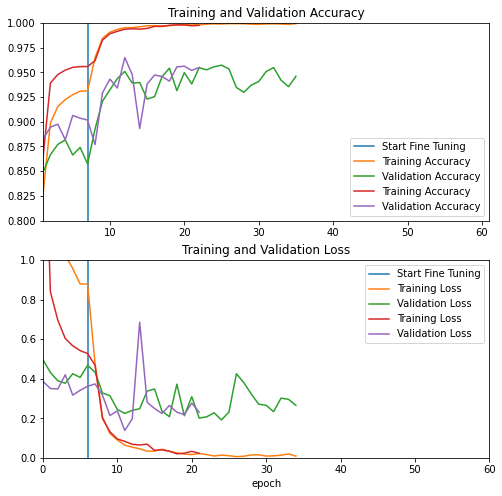

In [4]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.ylim([0.8,1.0])
plt.xlim((1, total_epochs+1))
plt.plot([initial_epochs,initial_epochs],
        plt.ylim(), label='Start Fine Tuning')
for acc, val_acc in zip(accs, val_accs):
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.ylim([0,1.0])
plt.xlim((0, total_epochs))
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
for loss, val_loss in zip(losses, val_losses):
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [5]:
model_num = MODEL_N

tf.keras.backend.clear_session()

test_datagen = ImageDataGenerator()
test_dataset = valid_datagen.flow_from_directory(test, 
                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
                                        class_mode='categorical', 
                                        shuffle=False)
y_true = test_dataset.classes

model_loaded0 = tf.keras.models.load_model(f'model{model_num}_fineTuned.h5')
model_loaded1 = tf.keras.models.load_model(f'model{model_num + 1}_fineTuned.h5')
# model_loaded2 = tf.keras.models.load_model(f'model{model_num + 2}_fineTuned.h5')
# model_loaded3 = tf.keras.models.load_model(f'model{model_num + 3}_fineTuned.h5')
# model_loaded4 = tf.keras.models.load_model(f'model{model_num + 4}_fineTuned.h5')
# model_loaded5 = tf.keras.models.load_model(f'model{model_num + 5}_fineTuned.h5')

pred0 = model_loaded0.predict(test_dataset)
pred1 = model_loaded1.predict(test_dataset)
# pred2 = model_loaded2.predict(test_dataset)
# pred3 = model_loaded3.predict(test_dataset)
# pred4 = model_loaded4.predict(test_dataset)
# pred5 = model_loaded5.predict(test_dataset)

# pred = pred0 + pred1 + pred2 + pred3 + pred4 + pred5
pred = pred0 + pred1
y_pred = np.argmax(pred, axis=1)

print(accuracy_score(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Found 54306 images belonging to 14 classes.
0.9878650609509079


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3062,0,76,0,1,1,24,1,0,0,0,2,1,3
1,0,1502,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,1903,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,3852,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,4062,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,5506,0,1,0,0,0,0,0,0
6,1,1,0,0,0,0,2655,0,0,0,0,0,0,0
7,12,0,1,2,0,9,10,2409,2,0,0,0,0,30
8,1,0,0,0,1,0,0,0,2140,0,0,0,0,10
9,0,0,0,0,0,0,0,0,0,371,0,0,0,0
